In [5]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU:", gpus)
else:
    print("No GPU detected. Using CPU.")

Num GPUs Available:  1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:

datasets = {"dataset_1": "/kaggle/input/autism/AutismDataset"}

# function to extract file paths and labels
def create_dataframe(dataset_path):
    data = {"file_path": [], "label": []}  # dictionary to hold file paths and labels

    # handle differently based on folder type
    for sub_dir in ["train", "test", "valid"]:
        folder_path = os.path.join(dataset_path, sub_dir)
        if not os.path.exists(folder_path):
            print("WARNING: Directory not found:", folder_path)
            continue

        if sub_dir == "valid":
            # valid has labeled subdirectories
            for label_dir, label in zip(["Autistic", "Non_Autistic"], [1, 0]):
                label_folder_path = os.path.join(folder_path, label_dir)
                if os.path.exists(label_folder_path):
                    for img_file in os.listdir(label_folder_path):
                        data["file_path"].append(os.path.join(label_folder_path, img_file))
                        data["label"].append(label)
        else:
            # `train` and `test` have images directly so infer labels from filenames
            for img_file in os.listdir(folder_path):
                if "Non_Autistic" in img_file:
                    label = 1
                elif "Autistic" in img_file:
                    label = 0
                else:
                    continue  # skip unknown files
                data["file_path"].append(os.path.join(folder_path, img_file))
                data["label"].append(label)

    return pd.DataFrame(data)

In [14]:

# create DataFrame for dataset
merged_df = create_dataframe(datasets["dataset_1"])

# save the dataset as a CSV file
merged_df.to_csv("merged_dataset.csv", index = False)
print("Dataset saved with", len(merged_df), "entries.")

# split the dataset using train_test_split
train_df, temp_df = train_test_split(merged_df, test_size = 0.3, stratify = merged_df["label"], random_state = 42)
valid_df, test_df = train_test_split(temp_df, test_size = 0.5, stratify = temp_df["label"], random_state = 42)

print("Train size:", len(train_df), "| Valid size:", len(valid_df), "| Test size:", len(test_df))

# load the merged dataset
merged_df = pd.read_csv("merged_dataset.csv")

# shuffle the data
train_df = train_df.sample(frac = 1, random_state = 42).reset_index(drop = True)
valid_df = valid_df.sample(frac = 1, random_state = 42).reset_index(drop = True)
test_df = test_df.sample(frac = 1, random_state = 42).reset_index(drop = True)
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

print("Train Dataset:")
print(train_df['label'].value_counts())

print("\nValidation Dataset:")
print(valid_df['label'].value_counts())

print("\nTest Dataset:")
print(test_df['label'].value_counts())

# save the shuffled datasets
train_df.to_csv("train.csv", index = False)
valid_df.to_csv("valid.csv", index = False)
test_df.to_csv("test.csv", index = False)

print("Shuffled datasets saved successfully!")

Dataset saved with 2940 entries.
Train size: 2058 | Valid size: 441 | Test size: 441
Train Dataset:
label
0    1029
1    1029
Name: count, dtype: int64

Validation Dataset:
label
1    221
0    220
Name: count, dtype: int64

Test Dataset:
label
0    221
1    220
Name: count, dtype: int64
Shuffled datasets saved successfully!


In [15]:

# define ImageDataGenerators with improved augmentation
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255.0,  # normalize pixel values to [0, 1]
    rotation_range = 5,  # rotate images by up to 5 degrees
    width_shift_range = 0.1,  # shift images horizontally by up to 10% of the width
    height_shift_range = 0.1,  # shift images vertically by up to 10% of the height
    horizontal_flip = True,  # flip images horizontally
    fill_mode = 'nearest'  # fill any missing pixels after transformations
)

valid_test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)  # no augmentation for validation & test

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df, x_col = "file_path", y_col = "label", target_size = (224, 224), batch_size = 32, class_mode = "binary")

valid_generator = valid_test_datagen.flow_from_dataframe(dataframe = valid_df, x_col = "file_path", y_col = "label", target_size = (224, 224), batch_size = 32, class_mode = "binary")

test_generator = valid_test_datagen.flow_from_dataframe(dataframe = test_df, x_col = "file_path", y_col = "label", target_size = (224, 224), batch_size = 32, class_mode = "binary", shuffle = False)

# Print label distribution for each generator
print("\nTrain Generator Label Distribution:")
print(Counter(train_generator.labels))

print("\nValidation Generator Label Distribution:")
print(Counter(valid_generator.labels))

print("\nTest Generator Label Distribution:")
print(Counter(test_generator.labels))

# Recreate the model architecture
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.6)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

Found 2058 validated image filenames belonging to 2 classes.
Found 441 validated image filenames belonging to 2 classes.
Found 441 validated image filenames belonging to 2 classes.

Train Generator Label Distribution:
Counter({0: 1029, 1: 1029})

Validation Generator Label Distribution:
Counter({1: 221, 0: 220})

Test Generator Label Distribution:
Counter({0: 221, 1: 220})


I0000 00:00:1745236293.972989      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 439ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step
Train F1 Score: 0.472 | ROC AUC: 0.4896
Validation F1 Score: 0.4858 | ROC AUC: 0.5199
Test F1 Score: 0.7754 | ROC AUC: 0.8567


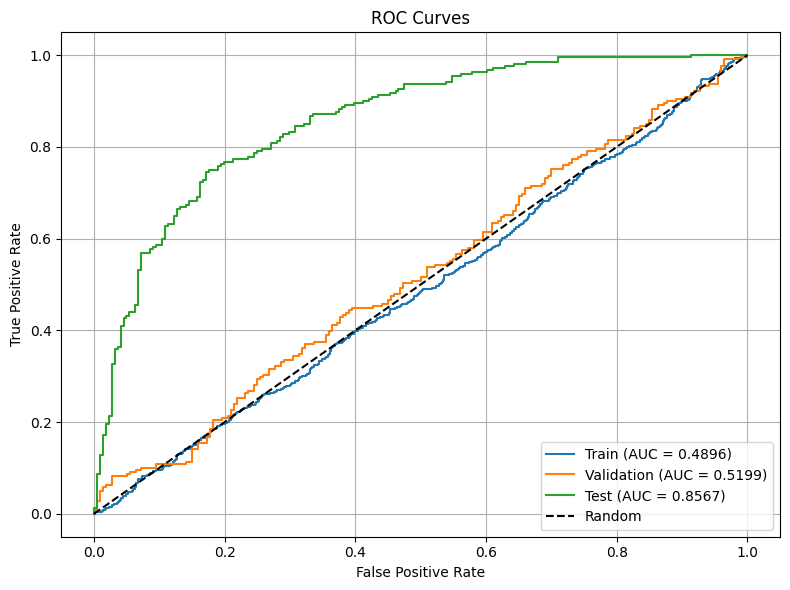

In [ ]:
# Load the full model
model_path = '/kaggle/input/modelmain/keras/default/1/densenet121_model.keras'
model = tf.keras.models.load_model(model_path)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

# Convert labels to numpy arrays
train_labels = np.array(train_generator.labels).astype(int)
val_labels = np.array(valid_generator.labels).astype(int)
test_labels = np.array(test_generator.labels).astype(int)

# Get raw prediction probabilities (for ROC)
train_probs = model.predict(train_generator).flatten()
val_probs = model.predict(valid_generator).flatten()
test_probs = model.predict(test_generator).flatten()

# Binarize predictions
train_preds = (train_probs > 0.5).astype(int)
val_preds = (val_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

# F1 Scores
train_f1 = f1_score(train_labels, train_preds)
val_f1 = f1_score(val_labels, val_preds)
test_f1 = f1_score(test_labels, test_preds)

# ROC AUC Scores
train_auc = roc_auc_score(train_labels, train_probs)
val_auc = roc_auc_score(val_labels, val_probs)
test_auc = roc_auc_score(test_labels, test_probs)

# Print all scores
print("Train F1 Score:", round(train_f1, 4), "| ROC AUC:", round(train_auc, 4))
print("Validation F1 Score:", round(val_f1, 4), "| ROC AUC:", round(val_auc, 4))
print("Test F1 Score:", round(test_f1, 4), "| ROC AUC:", round(test_auc, 4))

# Plot ROC curves
def plot_roc(labels, probs, label_name):
    fpr, tpr, _ = roc_curve(labels, probs)
    plt.plot(fpr, tpr, label=f"{label_name} (AUC = {roc_auc_score(labels, probs):.4f})")

plt.figure(figsize=(8, 6))
plot_roc(train_labels, train_probs, "Train")
plot_roc(val_labels, val_probs, "Validation")
plot_roc(test_labels, test_probs, "Test")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()